In [1]:
#- **OS**: SUSE Linux Enterprise Server 15 SP5
#- **CPU**: 2× AMD EPYC 7713 (128 cores, 256 threads)
#- **GPU**: NVIDIA A100-PCIE-40GB (40 GB)
#- **CUDA**: 12.4

import torch
import sys
sys.path.append('MOSAIC/PredictionUtils') # This is where the library is located

from Transformation_Model import KernelMetricNetwork
from ChemUtils import create_rxn_Mix_FP,show_rxn,show_mol
from NLPUtils import display_highlighted_diff,get_edit_distance,get_smarts_from_pred_text # This is the tool to study sequence-database referecing in Jupyter environment that supports HTML
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import RDKFingerprint, AllChem
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import faiss
from typing import List,Tuple
from rdkit import RDLogger     
from faiss import write_index, read_index

RDLogger.DisableLog('rdApp.*')   



In [2]:
def load_model(model, filename):
    model.load_state_dict(torch.load(filename))
    return model    

KMN_cpth = 'best_model_50ep_4096batchsize_AdamW.pth'

model = load_model(KernelMetricNetwork(2048*3, 2285), KMN_cpth)
model.eval();  # Set to evaluation mode
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device);


# FAISS Index Path
index = read_index("RSFP_Index.index") # testing reading the file
index.nprobe = 5 # Consider top 5 cloest voronois for predictions 

# Pistachio Dataframe
df = pickle.load(open('RSFP_Train_Quadrant_df.pkl','rb'))

# Its not necessary to put the faiss index on GPU, but it runs faster if you are predicting a lot of reactions

# if torch.cuda.is_available:
#     print('FAISS ->>> GPU') 
#     res = faiss.StandardGpuResources()
#     index = faiss.index_cpu_to_gpu(res, 0, index) 
#     print('FAISS on GPU!')

def predict_rxn(rxn, 
                n_expert = 3, 
                verbose = False,
                beam_size = 20,
                beam_group = 2,
                return_sequence = 20,
                diversity_penalty = 0.1,
                run_prediction = True,
                show_expert_reagent_info = False,
                show_reference = True,
                n_references = 1,
                show_cloest_rxn_in_database = True,
                HF_HOME_Directory = 'LLaMA/',
                base_model_path = 'llama-3.1-8B-Instruct'
                expert_adapter_path = 'Expert_Model_Checkpoints_RSFP/'
               ):
    
    if type(rxn) == type([]):
        clean_reactions = rxn
    elif type(rxn) == type(''):
        clean_reactions = [rxn]
    
    fp_size = 1024


    test_features = []
    with torch.no_grad():

        for i in range(len(clean_reactions)):
            rxn = clean_reactions[i]
            

            rxn_fp = create_rxn_Mix_FP(rxn, rxnfpsize=fp_size, pfpsize=fp_size, useChirality=True) 
   
            rxn_fp = np.concatenate((rxn_fp[1],rxn_fp[2],rxn_fp[0]), axis = -1) # reactant, diff, product

            # This considers we are only predicting a few reactions. But for other purposes, it can be optimized for batch processing
            feat = model.get_embeddings(torch.from_numpy(rxn_fp).view(1,-1).float().to(device)) # Using pre-trained embeddings

            test_features.append(feat.cpu().numpy())

    test_features = np.array(test_features).reshape((len(clean_reactions),-1))
    
        
    
    distance, cell_ids = index.quantizer.search(test_features, k=n_expert)
    individual_distance, individual_ids = index.search(test_features, k=n_expert)
    
    if verbose:
        print('You have requested {n_expert} experts and here is the domain of knowledge of these experts:'.format(n_expert = n_expert))
        print()
        # Print overview before predictions if verbose
        for i,rxn in enumerate(clean_reactions):
            print('-'*50)
            print('Rxn.' + str(i+1) +':',rxn)
            
            show_rxn(rxn)
            
            print()
            if show_cloest_rxn_in_database:
                
                closest_ref_rxn = df.iloc[individual_ids[i,0]].reaction
                print('closest reference dist:{dist}, reaction:{rxn}'.format(dist = individual_distance[i,0],
                                                                          rxn = closest_ref_rxn)
                     )
                show_rxn(closest_ref_rxn)
            
            for k in range(n_expert):
                print()
                print('*'*50)
               
                print('Top-' + str(k+1))
                print('Expert ID:' , cell_ids[i][k])
                print('Expert Centroid Distances' ,f"{distance[i][k]:.2f}")
                sub_df = df[df['quadrant'].values == cell_ids[i][k]]
                displaydict = dict(sub_df['namerxndef'].value_counts())
                print('Total Rxns:', len(sub_df))
                for namedef, counts in displaydict.items():
                    percentage = 100*counts/len(sub_df)
                    
                    print(namedef, f"{percentage:.2f}%")
                
                if show_expert_reagent_info:
                    # Not recommended to print everything
                    # this section will display the reagent statistics if chosen from the function
                    displaydict = dict(sub_df['agent_name'].value_counts()) 
                    for namedef, counts in displaydict.items():
                        percentage = 100*counts/len(sub_df)
                        print(namedef, f"{percentage:.2f}%")
                
                
    if not(run_prediction):
        
        return
           
   
    print('Expert Predictions:')
    for i,rxn in enumerate(clean_reactions):
        
        print('>'*50)
        print('Predicting Reaction '+str(i+1) +': '+ rxn)
        for k in range(n_expert):
            
                 
            config = {
                      'HF_HOME_PATH':HF_HOME_Directory',
                      'base_model_path': base_model_path,
                      'finetune_adaptor_path': expert_adapter_path,
                      'rxn':rxn,
                      'rxn_index':i+1,
                      'expert_id':cell_ids[i][k],
                      'beam_size':beam_size,
                      'beam_group':beam_group,
                      'return_sequence':return_sequence,
                      'diversity_penalty':diversity_penalty,}
            
            assert os.path.exists(os.path.join(config['finetune_adaptor_path'], 'Expert_' + str(config['expert_id']))), print('Assertion Error: Expert ' + str(config['expert_id'])+ ' does not exist!')
            
            pickle.dump(config,open('prediction.config','wb')
                       )
            
            os.system('sh run_prediction.sh > output')
            #os.system('rm output')
            
            all_valid_predictions = pickle.load(open('Prediciton_from_{expert}.pkl'.format(expert = cell_ids[i][k]), 'rb'))
            os.system('rm Prediciton_from_{expert}.pkl'.format(expert = cell_ids[i][k]))
            
            
            
            
            for pred_index,pred in enumerate(all_valid_predictions):
                
                smarts = get_smarts_from_pred_text(pred)
                
                try:
                    show_rxn(smarts)
                except:
                    print('extracted invalid SMARTS:{smarts}'.format(smarts = smarts))
                
                
                print('Expert: ' + str(k+1) + '\n' + 'Prediction:'+str(pred_index+1))
                print()
                print(pred)
                
                
                if show_reference:
                    print()
                    print()
                    procedure = pred.split('Procedure:\n')[1].split('\n')[0]
                    
                    sub_df = df[df['quadrant'].values == cell_ids[i][k]]
                    reference_distances = get_edit_distance(procedure, sub_df)
                    
                    distance_index = np.argsort(reference_distances)
                    
                    assert len(distance_index) >= n_references
                    
                    for j in range(n_references):
                        print('reference {ref_index} \ndistance: {dist} \nreference reaction: {rxn}'.format(
                            ref_index = j+1,
                            dist = reference_distances[distance_index[j]],
                            rxn = sub_df.iloc[distance_index[j]].reaction,
                            
                        ) 
                             )
                        
                        try:
                            print('Displaying Possible Reference Reaction')
                            show_rxn(sub_df.iloc[distance_index[j]].smiles)
                        except:
                            print('Refernce Reaction Invliad')
                            
                        
                        
                        display_highlighted_diff(sub_df.iloc[distance_index[j]]['paragraphText'], procedure)
             

Using 2285 classes predictions


/tmp/ipykernel_2150004/2701523854.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


# Prediction Console

You have requested 2 experts and here is the domain of knowledge of these experts:

--------------------------------------------------
Rxn.1: CC(C)(OC(N1CCN(C2=CC=C(Br)C=C2)CC1)=O)C.COC3CCNCC3>>CC(C)(OC(N4CCN(C5=CC=C(N6CCC(OC)CC6)C=C5)CC4)=O)C


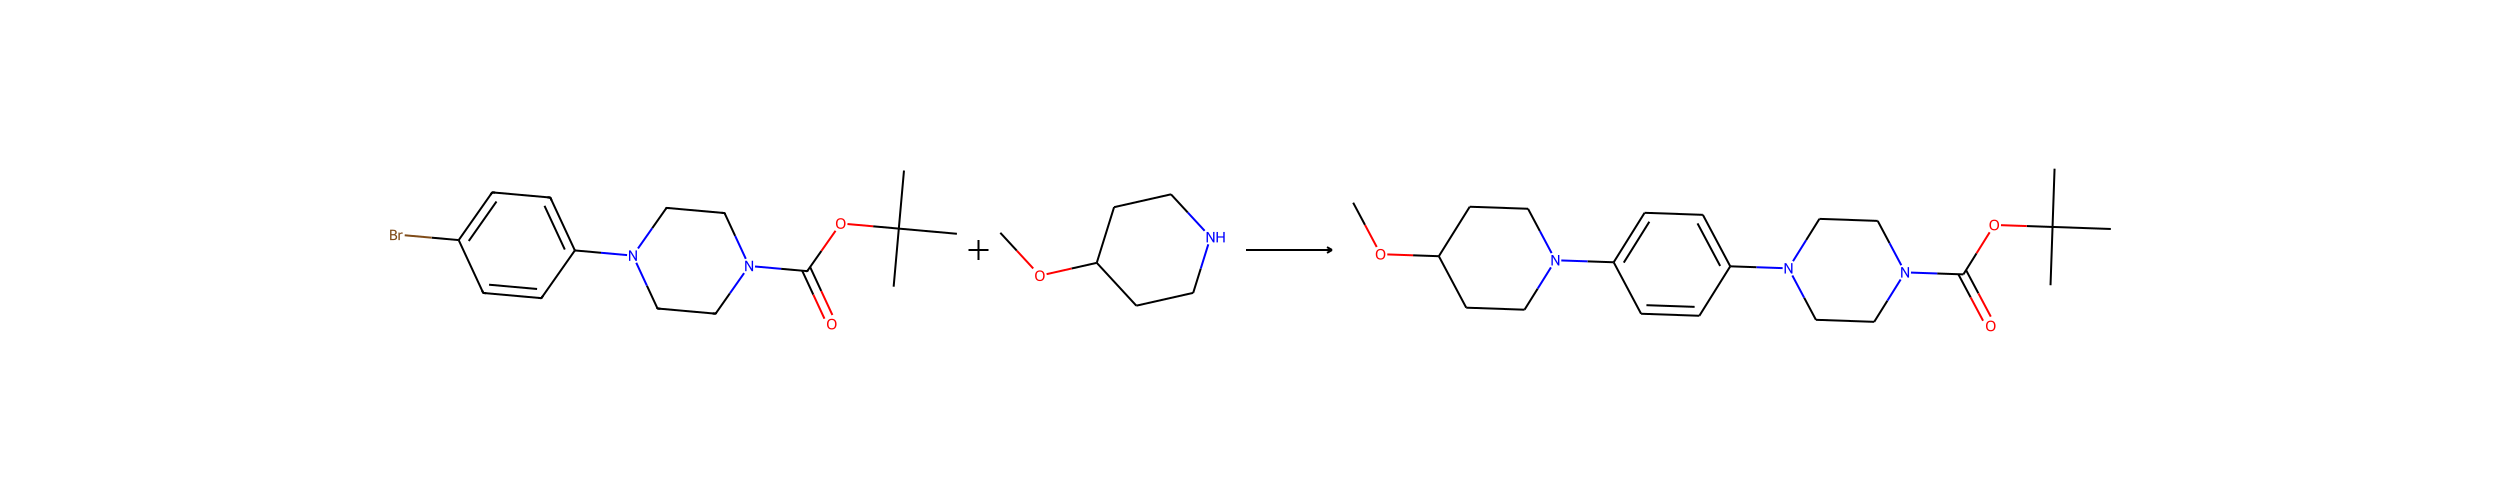



**************************************************
Top-1
Expert ID: 2266
Expert Centroid Distances 49.89
Total Rxns: 836
Bromo Buchwald-Hartwig amination 37.44%
Bromo N-arylation 8.97%
Bromo Goldberg reaction 6.22%
Palladium-catalyzed direct arylation 0.36%
Pyrrolidine synthesis 0.36%
Urea + ester + halide reaction 0.12%
Phosphinic P-alkylation 0.12%
Acetate salt formation 0.12%
Isoquinolone synthesis 0.12%
Bromo aminocarbonylation 0.12%
Bischler-Mohlau indole synthesis 0.12%
Cyanoalkane arylation 0.12%
Goldberg reaction 0.12%
Bromo to isocyano 0.12%
Racemization 0.12%
Bromo N-alkylation 0.12%
Bromo to mesyl 0.12%
N-Boc protection 0.12%

**************************************************
Top-2
Expert ID: 2398
Expert Centroid Distances 58.29
Total Rxns: 722
Bromo Buchwald-Hartwig amination 81.30%
Bromo N-arylation 6.65%
Bromo Goldberg reaction 0.55%
Expert Predictions:
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Predicting Reaction 1: CC(C)(OC(N1CCN(C2=CC=C(Br)C=C2)CC1)=O)C.COC

Loading checkpoint shards: 100%|██████████| 4/4 [00:55<00:00, 13.88s/it]
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


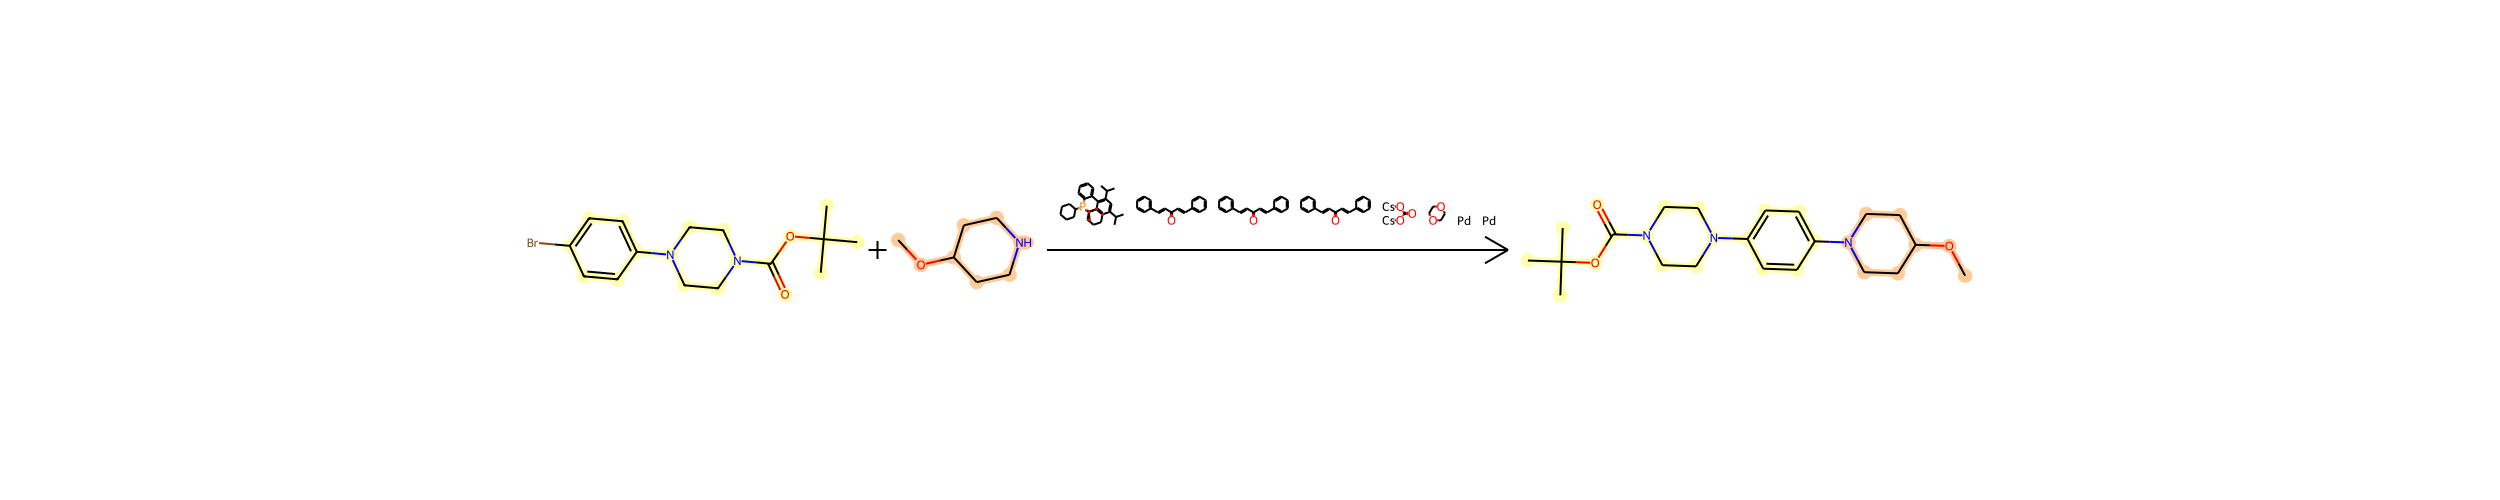

Expert: 1
Prediction:1


Product (SMILES): ['COC1CCN(c2ccc(N3CCN(C(=O)OC(C)(C)C)CC3)cc2)CC1']
Reactant (SMILES): ['CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2)CC1', 'COC1CCNCC1']
Reaction SMARTS: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][N:11]([CH2:12][CH2:13]1)[c:14]1[cH:15][cH:16][c:17]([cH:18][cH:19]1)Br.[CH3:20][O:21][CH:22]1[CH2:23][CH2:24][NH:25][CH2:26][CH2:27]1>CC(C)c1cc(c(c(c1)C(C)C)-c1ccccc1P(C1CCCCC1)C1CCCCC1)C(C)C.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(O[Cs])O[Cs].C1COCCO1.[Pd].[Pd]>[CH3:20][O:21][CH:22]1[CH2:23][CH2:24][N:25]([CH2:26][CH2:27]1)[c:17]1[cH:18][cH:19][c:14]([cH:15][cH:16]1)[N:11]1[CH2:10][CH2:9][N:8]([CH2:13][CH2:12]1)[C:6](=[O:7])[O:5][C:2]([CH3:1])([CH3:3])[CH3:4] |f:3.4.5.8.9|
Reagents (SMILES): ['O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.[Pd].[Pd]', 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1', 'O=C(O[Cs])O[Cs]

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


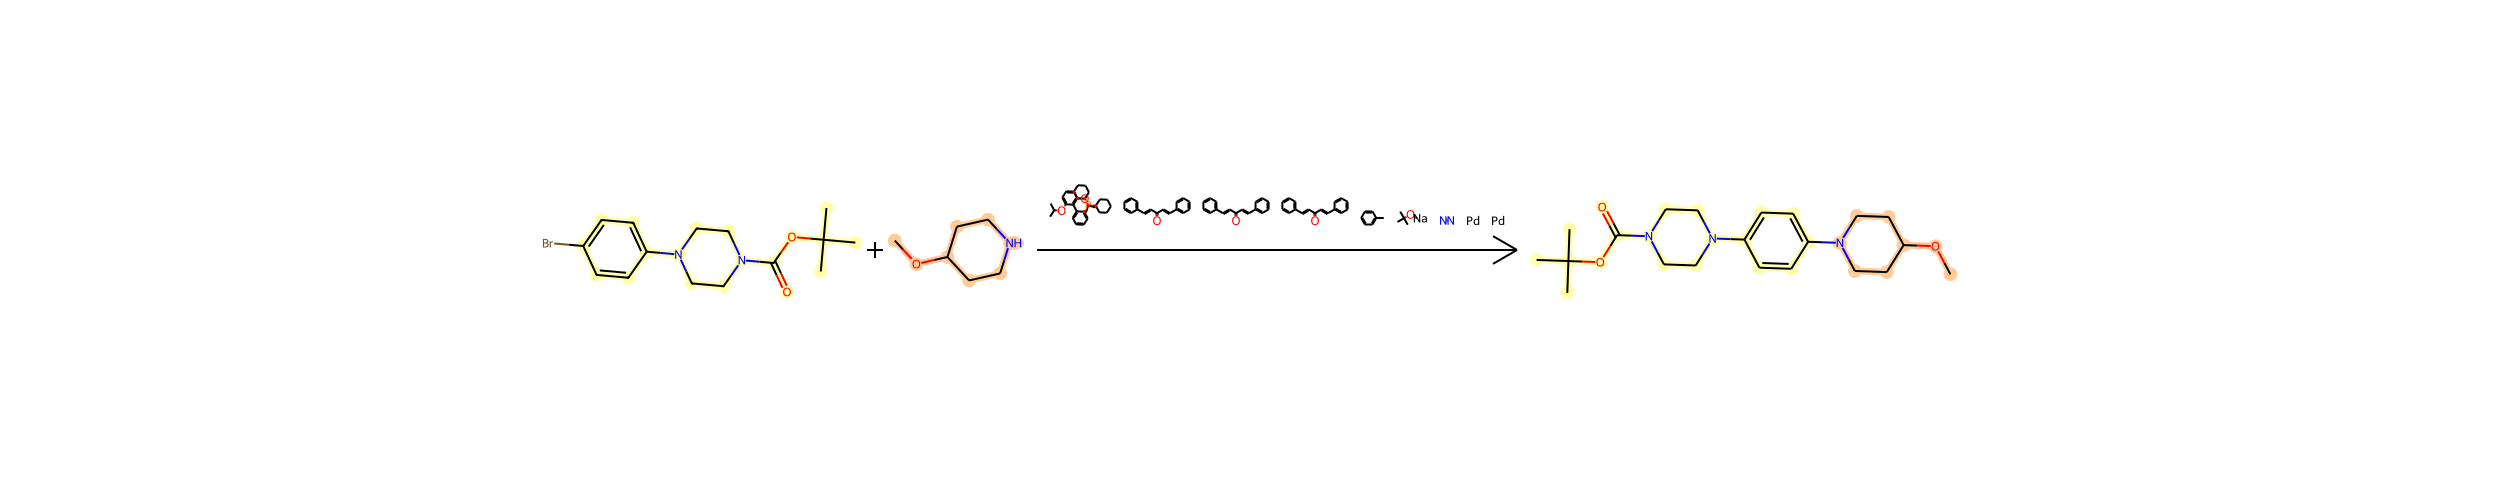

Expert: 2
Prediction:1


Product (SMILES): ['COC1CCN(c2ccc(N3CCN(C(=O)OC(C)(C)C)CC3)cc2)CC1']
Reactant (SMILES): ['CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2)CC1', 'COC1CCNCC1']
Reaction SMARTS: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][N:11]([CH2:12][CH2:13]1)[c:14]1[cH:15][cH:16][c:17]([cH:18][cH:19]1)Br.[CH3:20][O:21][CH:22]1[CH2:23][CH2:24][NH:25][CH2:26][CH2:27]1>CC(C)Oc1cccc(c1-c1ccccc1P(C1CCCCC1)C1CCCCC1)OC(C)C.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.Cc1ccccc1.CC(C)(C)O[Na].N#N.[Pd].[Pd]>[CH3:20][O:21][CH:22]1[CH2:23][CH2:24][N:25]([CH2:26][CH2:27]1)[c:17]1[cH:18][cH:19][c:14]([cH:15][cH:16]1)[N:11]1[CH2:12][CH2:13][N:8]([CH2:9][CH2:10]1)[C:6](=[O:7])[O:5][C:2]([CH3:1])([CH3:3])[CH3:4] |f:3.4.5.9.10|
Reagents (SMILES): ['CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1', 'O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.[Pd].[Pd]', 'CC(C)(C)O[Na]']
Solvent (

In [5]:
# Inference with each expert is expected to take ~120s per transformation on a desktop computer equipped with a single NVIDIA A100.
predict_rxn(rxn = [
                   r'CC(C)(OC(N1CCN(C2=CC=C(Br)C=C2)CC1)=O)C.COC3CCNCC3>>CC(C)(OC(N4CCN(C5=CC=C(N6CCC(OC)CC6)C=C5)CC4)=O)C',
                   
                  ],

            n_expert = 2,
            verbose = True,
            beam_size = 20,
            beam_group = 2, # If this is set smaller than 2, traditional beam search is used.
            return_sequence = 20,
            show_expert_reagent_info = False,
            show_cloest_rxn_in_database = False,
            run_prediction = True,
            
            # Below is the referencing function, if prediction is not run, the referencing will not be run
            show_reference = False,
            n_references = 2,
            
)